This notebook was downloaded from https://willcox-research-group.github.io/rom-operator-inference-Python3/source/tutorials/heat_equation.html

# Heat Equation

The fundamental goal of model reduction is to efficiently make physics-based predictions. Given synthetic or experimental data that was generated or collected under a certain set of conditions, we aim to construct a cost-effective model that produces accurate solutions under new sets of conditions. This tutorial explores the following prediction problems for the heat equation example of {cite}`peherstorfer2016opinf`:
1. Predicting **forward in time**.
2. Using new time-dependent **boundary conditions**.
3. Changing the **system parameters** (e.g., coefficients in the governing equation).

## Problem Statement

:::{admonition} Governing Equations
:class: attention

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $x$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$. We consider the one-dimensional heat equation with non-homogeneous Dirichlet boundary conditions,

\begin{align*}
    &\frac{\partial}{\partial t} q(x,t;\mu) = \mu\frac{\partial^2}{\partial x^2}q(x,t;\mu)
    & x &\in\Omega,\quad t\in[0,T],
    \\
    &q(0,t;\mu) = q(L,t;\mu) = u(t)
    & t &\in[0,T],
    \\
    &q(x,0;\mu) = \big(e^{\alpha(x - 1)} + e^{-\alpha x} - e^{-\alpha}\big)u(0)
    & x &\in \Omega,
\end{align*}

where the constant $\mu > 0$ is the thermal diffusivity, $\alpha>0$ is constant, and $q(x,t;\mu)$ is the unknown state variable. This is a model for a one-dimensional rod conducting heat with a fixed initial heat profile. The temperature at the ends of the rod are governed by the input function $u(t)$, but  heat is allowed to diffuse through the rod and flow out at the ends of the domain. We aim to numerically solve for $q(x,t;\mu)$ efficiently for all $t \in [0,T]$ and/or for various choices of $u(t)$ and $\mu$.
:::

:::{note}
This problem can be solved with a straightforward discretization of the spatial domain $\Omega$ with little computational effort, so using model reduction to speed up the computation is not highly beneficial. However, the way that the user interacts with the package for this problem is highly similar for more complex problems.
:::

## Prediction in Time

Our first objective is to get solutions in time beyond a set of available training data.

:::{image} ../../images/summary.svg
:align: center
:width: 80 %
:::

:::{admonition} Objective
:class: attention

Construct a reduced-order model (ROM) of the heat equation that is **predictive in time**. In other words, we will observe data for $t \in [0, T']$ with $T' < T$, use that data to construct the ROM, and use the ROM to predict the solution for the entire time domain $[0,T]$.
:::

### Full-order Model Definition

As in the last tutorial, we use a centered finite difference approximation for the spatial derivative to arrive at a first-order system, this time of the form

$$
    \frac{\text{d}}{\text{d}t}\mathbf{q}(t;\mu)
    = \mathbf{A}(\mu)\mathbf{q}(t;\mu) + \mathbf{B}(\mu)u(t),
    \qquad
    \mathbf{q}(0;\mu)
    = \mathbf{q}_0.
$$ (eq_heat_fom_parametric)

:::{dropdown} Discretization details

We take an equidistant grid $\{x_i\}_{i=0}^{n+1} \subset \Omega$,

\begin{align*}
    0 &= x_0 < x_1 < \cdots < x_n < x_{n+1} = L
    &
    &\text{and}
    &
    \delta x &= \frac{L}{n+1} = x_{i+1} - x_{i},\quad i=1,\ldots,n-1.
\end{align*}

The boundary conditions prescribe $q(x_0,t) = q(x_{n+1},t) = u(t)$. Our goal is to compute $q(x,t)$ at the interior spatial points $x_{1},x_{2},\ldots,x_{n}$ for various $t\in[0,T]$, so we consider the state vector $\mathbf{q}(t) = [~q(x_{1}, t)~\cdots~q(x_{n}, t)~]^{\top}\in\mathbb{R}^n$ and derive a system governing the evolution of $\mathbf{q}(t)$ in time.

Approximating the spatial derivative with a central finite difference approximation,

$$
    \frac{\partial^2}{\partial x^2}q(x,t)
    \approx \frac{q(x-\delta x,t) - 2q(x,t) + q(x+\delta x,t)}{(\delta x)^2},
$$

we arrive at the following matrices for the full-order model.

\begin{align*}
    \mathbf{A}(\mu) &= \frac{\mu}{(\delta x)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{B}(\mu) &= \frac{\mu}{(\delta x)^2}\left[\begin{array}{c}
        1 \\ 0 \\ \vdots \\ 0 \\ 1
    \end{array}\right]\in\mathbb{R}^{n}.
\end{align*}
:::

The state $\mathbf{q}(t;\mu)$ implicity depends on the parameter $\mu$ because the operators $\mathbf{A}(\mu)$ and $\mathbf{B}(\mu)$ are parameterized by $\mu$.
For now, we set $\mu = 1$ and simply write

$$
    \frac{\text{d}}{\text{d}t}\mathbf{q}(t)
    = \mathbf{A}\mathbf{q}(t) + \mathbf{B}u(t),
    \qquad
    \mathbf{q}(0)
    = \mathbf{q}_0.
$$

This is the _full-order model_ (FOM), which we will use to generate training data for the time domain $[0, T'] \subset [0, T]$.

### Training Data Generation

Let $L = T = \mu = 1$, $\alpha = 100$, and suppose for now that the boundary conditions are given by the constant input function $u(t) \equiv 1$.
We begin by simulating the full-order system described above with a uniform time step $\delta t = 10^{-3}$, yielding $10^3 + 1 = 1001$ total time steps (1000 steps past the initial condition).
We will assume that we can only observe the first $k = 100$ time steps and use the ROM to predict the remaining $901$ steps.

In [2]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [3]:
# Matplotlib customizations.
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", dpi=300, figsize=(9, 3))
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=True)

# Pandas display options.
pd.options.display.float_format = "{:.4%}".format

In [4]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
K = T*10**3 + 1                 # Temporal grid size.
t = np.linspace(0, T, K)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [5]:
# Construct the full-order state matrix A.
dx2inv = 1 / dx**2
diags = np.array([1, -2, 1]) * dx2inv
A = sparse.diags(diags, [-1, 0, 1], (n, n))

# Construct the full-order input matrix B.
B = np.zeros_like(x)
B[0], B[-1] = dx2inv, dx2inv

In [44]:
B

array([16384.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
      

In [6]:
# Define the inputs.
input_func = np.ones_like       # Constant input function u(t) = 1.
U_all = input_func(t)           # Inputs over the time domain.

# Construct the initial condition.
alpha = 100
q0 = np.exp(alpha*(x-1)) + np.exp(-alpha*x) - np.exp(-alpha)

print(f"shape of A:\t{A.shape}")
print(f"shape of B:\t{B.shape}")
print(f"shape of q0:\t{q0.shape}")

shape of A:	(127, 127)
shape of B:	(127,)
shape of q0:	(127,)


Since this is a diffusive problem, we will use the implicit (backward) Euler method for solving the ODEs.
For the problem $\frac{\text{d}}{\text{d}t}\mathbf{q}(t) = \mathbf{F}(t, \mathbf{q}(t), \mathbf{u}(t))$, implicit Euler is defined by the rule

$$
    \mathbf{q}_{j+1} = \mathbf{q}_{j} + \delta t \mathbf{F}(t_{j+1},\mathbf{q}_{j+1},u_{j+1}),
$$

where $\mathbf{q}_{j} := \mathbf{q}(t_{j})$ and $u_{j} := u(t_{j})$.
With the form $\mathbf{F}(t,\mathbf{q}(t),u(t)) = \mathbf{A}\mathbf{q}(t) + \mathbf{B}u(t)$, this becomes

$$
    \mathbf{q}_{j+1} = (\mathbf{I} - \delta t \mathbf{A})^{-1}\left(\mathbf{q}_{j} + \delta t \mathbf{B} u_{j+1}\right),
$$

where $\mathbf{I}$ is the identity matrix.

In [7]:
def implicit_euler(t, q0, A, B, U):
    """Solve the system

        dq / dt = Aq(t) + Bu(t),    q(0) = q0,

    over a uniform time domain via the implicit Euler method.

    Parameters
    ----------
    t : (k,) ndarray
        Uniform time array over which to solve the ODE.
    q0 : (n,) ndarray
        Initial condition.
    A : (n, n) ndarray
        State matrix.
    B : (n,) or (n, 1) ndarray
        Input matrix.
    U : (k,) ndarray
        Inputs over the time array.

    Returns
    -------
    q : (n, k) ndarray
        Solution to the ODE at time t; that is, q[:,j] is the
        computed solution corresponding to time t[j].
    """
    # Check and store dimensions.
    k = len(t)
    n = len(q0)
    B = np.ravel(B)
    assert A.shape == (n, n)
    assert B.shape == (n,)
    assert U.shape == (k,)
    I = np.eye(n)

    # Check that the time step is uniform.
    dt = t[1] - t[0]
    assert np.allclose(np.diff(t), dt)

    # Factor I - dt*A for quick solving at each time step.
    factored = la.lu_factor(I - dt*A)

    # Solve the problem by stepping in time.
    q = np.empty((n, k))
    q[:,0] = q0.copy()
    for j in range(1, k):
        q[:, j] = la.lu_solve(factored, q[:, j-1] + dt*B*U[j])

    return q

In [8]:
# Compute snapshots by solving the equation with implicit_euler().
Q_all = implicit_euler(t, q0, A, B, U_all)

# Retain only the first k snapshots/inputs for training the ROM.
k = 100                         # Number of training snapshots.
t_train = t[:k]                 # Temporal domain for training snapshots.
Q = Q_all[:, :k]                # Observed snapshots.

We also need the time derivatives $\frac{d\mathbf{q}}{dt}$ of the training snapshots. If $\mathbf{A}$ and $\mathbf{B}$ are known, we can set $\dot{\mathbf{q}}_{j} = \mathbf{A}\mathbf{q}_{j} + \mathbf{B}u_{j}$. If we do not have access to $\mathbf{A}$ and $\mathbf{B}$, we can estimate the time derivatives using finite differences.

In [9]:
# Estimate time derivatives (dq/dt) for each training snapshot.
Qdot_train = (Q[:, 1:] - Q[:, :-1]) / dt
Q_train = Q[:, 1:]              # Training snapshots.
U_train = U_all[1:k]            # Training inputs.

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")
print(f"shape of U_train:\t{U_train.shape}")

shape of Q_train:	(127, 99)
shape of Qdot_train:	(127, 99)
shape of U_train:	(99,)


Finally, we visualize the snapshots to get a sense of how the solution looks qualitatively.

In [10]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 10, 20, 40, 80, 160, 320, 640]
    sample_columns = [0] + [2**d for d in range(10)]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    leftBC, rightBC = [input_func(x_all[0])], [input_func(x_all[-1])]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

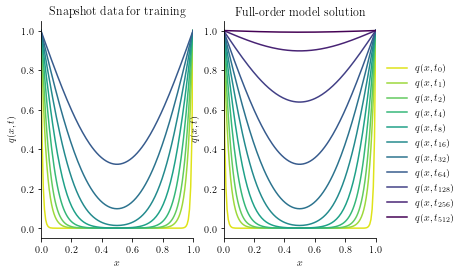

In [11]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q, "Snapshot data for training", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

### ROM Construction

Now that we have snapshot data $\mathbf{Q} \in \mathbb{R}^{n \times k}$, we can construct [a basis matrix](sec-basis-computation) $\mathbf{V}_r \in \mathbb{R}^{n \times r}$. The basis matrix relates the high-dimensional and low-dimensional by $\mathbf{q}(t) = \mathbf{V}_{r}\widehat{\mathbf{q}}(t)$.

For operator inference (OpInf), we often use the [proper orthogonal decomposition](subsec-pod) (POD) basis. The integer $r$, which defines the dimension of the reduced-order model to be constructed, is usually determined by how quickly the singular values of $\mathbf{Q}$ decay. In this example, we choose the minimal $r$ such that the [residual energy](subsec-basis-size) is less than a given tolerance $\varepsilon$, i.e.,

$$
\frac{\sum_{j=r + 1}^{k}\sigma_{j}^{2}}{\sum_{j=1}^{k}\sigma_{j}^{2}} = \frac{||\mathbf{Q} - \mathbf{V}_r \mathbf{V}_r^{\top}\mathbf{Q}||_{F}^{2}}{||\mathbf{Q}||_{F}^{2}} < \varepsilon.
$$

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 8


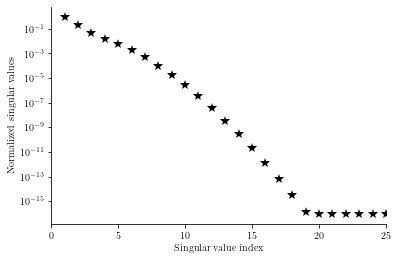

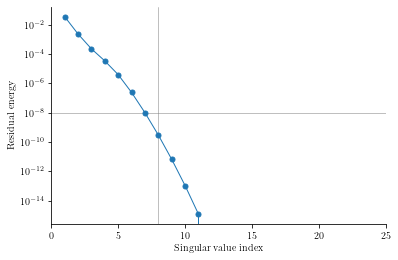

In [12]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.pre.PODBasis().fit(Q, residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 25)

# Check the decay of the residual energy based on the singular values.
basis.plot_residual_energy(threshold=1e-8)
plt.xlim(0, 25)
plt.show()

::::{margin}
:::{note}
In this case, since $u(t) \equiv 1$ is constant, we could equivalently set `modelform="cA"` to learn a ROM of the form $\frac{\text{d}}{\text{d}t}\widehat{\mathbf{q}}(t) = \widehat{\mathbf{c}} + \widehat{\mathbf{A}}\widehat{\mathbf{q}}(t)$, where $\widehat{\mathbf{c}}$ is a constant term.
There is no difference between the two models, i.e., $\widehat{\mathbf{c}} = \widehat{\mathbf{B}}u(t) = \widehat{\mathbf{B}}$, except that `modelform="AB"` allows us to use different inputs for $u(t)$ later on.
:::
::::

Now we can learn the reduced model with OpInf.
Because the full-order model is of the form $\frac{\text{d}}{\text{d}t}\mathbf{q}(t) = \mathbf{A}\mathbf{q}(t) + \mathbf{B}u(t)$, we set the form of the ROM to $\frac{\text{d}}{\text{d}t}\widehat{\mathbf{q}}(t) = \widehat{\mathbf{A}}\widehat{\mathbf{q}}(t) + \widehat{\mathbf{B}}u(t)$ by specifying `modelform="AB"`.

In [13]:
# Train the model.
rom = opinf.ContinuousOpInfROM(modelform="AB")
rom.fit(basis=basis, states=Q_train, ddts=Qdot_train, inputs=U_train)
print(rom)

Reduced-order model structure: dq / dt = Aq(t) + Bu(t)
Full-order dimension    n = 127
Input/control dimension m = 1
Reduced-order dimension r = 8


### ROM Evaluation

Like the FOM, we integrate the learned ROM using the implicit Euler method, using the reduced-order operators $\widehat{\mathbf{A}}$ and $\widehat{\mathbf{B}}$ and the initial condition $\widehat{\mathbf{q}}_{0} = \mathbf{V}^{\mathsf{T}}\mathbf{q}_{0}$.
The resulting low-dimensional state vectors are decoded back to the full-dimensional space via $\mathbf{q}(t) = \mathbf{V}_{r}\widehat{\mathbf{q}}(t)$.

In [14]:
# Express the initial condition in the coordinates of the basis.
q0_ = basis.encode(q0)

# Solve the reduced-order model using Implicit Euler.
Q_ROM = basis.decode(implicit_euler(t, q0_, rom.A_.entries, rom.B_.entries, U_all))

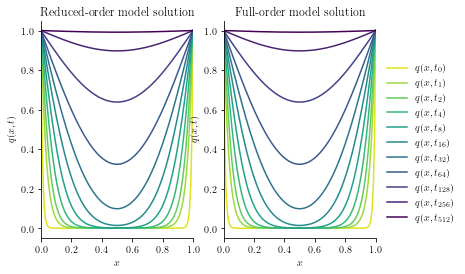

In [15]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q_ROM, "Reduced-order model solution", ax1)
plot_heat_data(Q_all, "Full-order model solution", ax2)
ax1.legend([])
plt.show()

To quantify the accuracy of the ROM, we evaluate the ROM solution error in the Frobenius norm and compare it to the projection error,

$$
    \text{err}_{\text{ROM}}
    = \frac{||\mathbf{Q}_{\text{all}} - \mathbf{Q}_{\text{ROM}}||_F}{||\mathbf{Q}_{\text{all}}||_F},
    \qquad
    \text{err}_{\text{proj}}
    = \frac{||\mathbf{Q}_{\text{all}} - \mathbf{V}_{r}\mathbf{V}_{r}^{\top}\mathbf{Q}_{\text{all}}||_F}{||\mathbf{Q}_{\text{all}}||_F},
$$

where $\mathbf{Q}_{\text{all}}$ is the full-order model solution over the entire time domain and $\mathbf{Q}_{\text{ROM}}$ is the reduced-order model solution.

In [16]:
rel_froerr_projection = basis.projection_error(Q_all, relative=True)
rel_froerr_opinf = opinf.post.frobenius_error(Q_all, Q_ROM)[1]

print("Relative Frobenius-norm errors", '-'*33,
      f"projection error:\t{rel_froerr_projection:%}",
      f"OpInf ROM error:\t{rel_froerr_opinf:%}",
      sep='\n')

Relative Frobenius-norm errors
---------------------------------
projection error:	0.002573%
OpInf ROM error:	0.002577%


The ROM error cannot be better than the projection error, but the two are pretty close. We also compare the ROM error with the projection error as a function of time, i.e.,

$$
    \text{err}_{\text{ROM}}(t)
    = \frac{\|\mathbf{q}(t) - \mathbf{q}_{\text{ROM}}(t)\|_{2}}{\|\mathbf{q}(t)\|_{2}},
    \qquad
    \text{err}_{\text{proj}}(t)
    = \frac{\|\mathbf{q}(t) - \mathbf{V}_{r}\mathbf{V}_{r}^{\mathsf{T}}\mathbf{q}(t)\|_{2}}{\|\mathbf{q}(t)\|_{2}},
$$

where $\mathbf{q}(t)$ is the full-order solution and $\mathbf{q}_{\text{ROM}}(t)$ is the ROM solution at time $t$.

:::{tip}
In this problem, $\mathbf{q}(t) \to \mathbf{0}$ as $t$ increases, so a relative error may not be appropriate since $\|\mathbf{q}(t)\|_{2}$ appears in the denominator.
In situations like this, consider using the _normalized absolute error_ by replacing the denominator with $\max_{\tau\in[0,T]}\|\mathbf{q}(t)\|$, for example:
$$
    \text{err}_{\text{ROM}}(t)
    = \frac{\|\mathbf{q}(t) - \mathbf{q}_{\text{ROM}}(t)\|_{2}}{\max_{\tau\in[0,T]}\|\mathbf{q}(\tau)\|_{2}}.
$$

Use `normalize=True` in `opinf.post.lp_error()` to use this error measure instead of the relative error.
:::

In [17]:
projerr_in_time = opinf.post.lp_error(Q_all,
                                      basis.project(Q_all),
                                      normalize=True)[1]

def plot_errors_over_time(Zlist, labels):
    """Plot normalized absolute projection error and ROM errors
    as a function of time.

    Parameters
    ----------
    Zlist : list((n, k) ndarrays)
        List of reduced-order model solutions.
    labels : list(str)
        Labels for each of the reduced-order models.
    """
    fig, ax = plt.subplots(1, 1)
    
    ax.semilogy(t, projerr_in_time, "C3", label="Projection Error")
    colors = ["C0", "C5"]
    for Z, label, c in zip(Zlist, labels, colors[:len(Zlist)]):
        rel_err = opinf.post.lp_error(Q_all, Z, normalize=True)[1]
        plt.semilogy(t, rel_err, c, label=label)

    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel("Normalized absolute error")
    ax.legend(loc="lower right")
    plt.show()

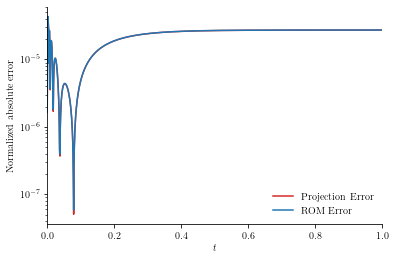

In [18]:
plot_errors_over_time([Q_ROM], ["ROM Error"])

### Comparison with Intrusive Projection

In the limit as the amount of training data $k$ and the dimension $r$ increases, the reduced operators $\widehat{\mathbf{A}}$ and $\widehat{\mathbf{B}}$ learned through OpInf converge to the corresponding operators obtained through _intrusive projection_,

\begin{align*}
    \widetilde{\mathbf{A}} &= \mathbf{V}_{r}^{\mathsf{T}} \mathbf{A} \mathbf{V}_{r},
    &
    \widetilde{\mathbf{B}} &= \mathbf{V}_{r}^{\mathsf{T}}\mathbf{B}.
\end{align*}

Computing $\widetilde{\mathbf{A}}$ and $\widetilde{\mathbf{B}}$ is considered "intrusive" because it requires explicit access to the full-order operators $\mathbf{A}$ and $\mathbf{B}$.

In [19]:
Vr = basis.entries
Atilde = Vr.T @ A @ Vr
Btilde = Vr.T @ B
q0_ = basis.encode(q0)
Q_ROM_intrusive = basis.decode(implicit_euler(t, q0_, Atilde, Btilde, U_all))

:::{tip}
The OpInf ROM classes, such as `ContinuousOpInfROM`, learn reduced-order model operators intrusively whenever the full-order operators are provided through the `known_operators` argument of `fit()`.
This argument should be a dictionary mapping the modelform key to the full-order operator.
If every full-order operator is provided, then the `states` and `ddts` arguments of `fit()` may be set to `None`, since there is no data-driven learning in this case.

```python
>>> rom_intrusive = opinf.ContinuousOpInfROM("AB")
>>> rom_intrusive.fit(basis, None, None, known_operators={"A": A, "B": B})
>>> np.all(rom_intrusive.A_.entries == Atilde)
True
>>> np.all(rom_intrusive.B_.entries[:, 0] == Btilde)
True

>>> Q_ROM_intrusive = basis.decode(implicit_euler(t, q0_, rom_intrusive.A_.entries, rom_intrusive.B_.entries, U_all))
```

If, for example, only the full-order operator $\mathbf{B}$ were known (but not $\mathbf{A}$), we can learn $\widehat{\mathbf{A}}$ through OpInf and $\widehat{\mathbf{B}}$ through intrusive projection:

```python
>>> rom_partially_intrusive = opinf.ContinuousOpInfROM("AB")
>>> rom_partially_intrusive.fit(basis, Q, Qdot, U, known_operators={"B": B})
>>> np.all(rom_partially_intrusive.A_.entries == Atilde)
False
>>> np.all(rom_partially_intrusive.B_.entries[:, 0] == Btilde)
True
```

:::

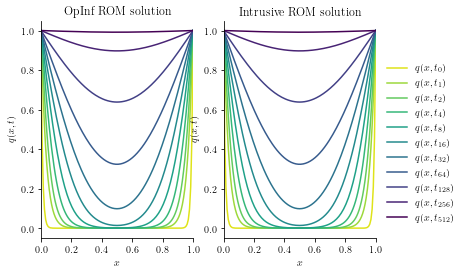

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q_ROM, "OpInf ROM solution", ax1)
plot_heat_data(Q_ROM_intrusive, "Intrusive ROM solution", ax2)
ax1.legend([])
plt.show()

In [21]:
rel_froerr_intrusive = opinf.post.frobenius_error(Q_all, Q_ROM_intrusive)[1]

print("Relative Frobenius-norm errors", '-'*33,
      f"projection error:\t{rel_froerr_projection:%}",
      f"OpInf ROM error:\t{rel_froerr_opinf:%}",
      f"intrusive ROM error:\t{rel_froerr_intrusive:%}",
      sep='\n')

Relative Frobenius-norm errors
---------------------------------
projection error:	0.002573%
OpInf ROM error:	0.002577%
intrusive ROM error:	0.003508%


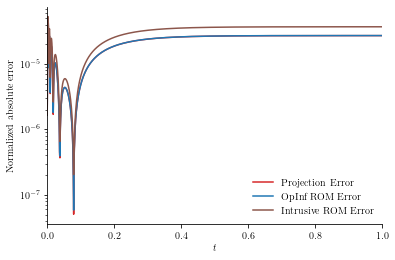

In [22]:
plot_errors_over_time([Q_ROM, Q_ROM_intrusive],
                      ["OpInf ROM Error", "Intrusive ROM Error"])

Let's repeat the experiment with different choices of $r$ to see how the size of the ROM affects its accuracy.

In [23]:
def run_trial(r):
    """Do OpInf / intrusive ROM prediction with r basis vectors."""
    basis.r = r
    q0_ = basis.encode(q0)

    # Construct and simulate the intrusive ROM.
    rom_intrusive = opinf.ContinuousOpInfROM("AB").fit(basis, None, None,
                                                       known_operators={"A":A, "B":B})
    Q_ROM_intrusive = basis.decode(implicit_euler(t, q0_,
                                                  rom_intrusive.A_.entries,
                                                  rom_intrusive.B_.entries, U_all))

    # Construct and simulate the operator inference ROM.
    rom_opinf = opinf.ContinuousOpInfROM("AB").fit(basis, Q_train, Qdot_train, U_train)
    Q_ROM_opinf = basis.decode(implicit_euler(t, q0_,
                                              rom_opinf.A_.entries,
                                              rom_opinf.B_.entries, U_all))

    # Calculate errors.
    projection_error = basis.projection_error(Q_all, relative=True)
    intrusive_error = opinf.post.frobenius_error(Q_all, Q_ROM_intrusive)[1]
    opinf_error = opinf.post.frobenius_error(Q_all, Q_ROM_opinf)[1]

    return projection_error, intrusive_error, opinf_error

In [24]:
def plot_state_error(rmax, runner, ylabel):
    """Run the experiment for r = 1, ..., rmax and plot results."""
    rs = np.arange(1, rmax+1)
    err_projection, err_intrusive, err_opinf = zip(*[runner(r) for r in rs])

    fig, ax = plt.subplots(1, 1)
    ax.semilogy(rs, err_projection, 'C3-',
                label="projection error", lw=1)
    ax.semilogy(rs, err_intrusive, 'C5+-',
                label="intrusive ROM error", lw=1, mew=2)
    ax.semilogy(rs, err_opinf, 'C0o-',
                label="OpInf ROM error", lw=1, mfc="none", mec="C0", mew=1.5)

    ax.set_xlim(rs.min(), rs.max())
    ax.set_xticks(rs, [str(int(r)) for r in rs])
    ax.set_xlabel(r"Reduced dimension $r$")
    ax.set_ylabel(ylabel)
    ax.legend(loc="upper right", fontsize=14, framealpha=1)
    ax.grid(ls=':')
    plt.show()

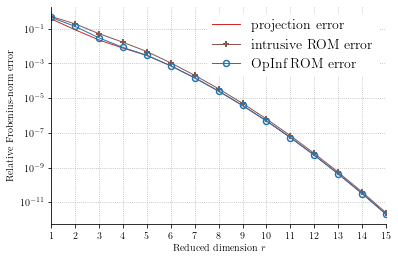

In [25]:
plot_state_error(15, run_trial, "Relative Frobenius-norm error")

:::{admonition} Takeaway
:class: attention
In this case, the operator inference and intrusive ROMs give essentially the same result.
However, the operator inference ROM successfully emulates the FOM **without explicit access to** $\mathbf{A}$ **and** $\mathbf{B}$.
:::

:::{admonition} On Convergence
:class: warning
The figure above conveys a sense of convergence: as the reduced dimension $r$ increases, the ROM error decreases. In more complex problems, **the error does not always decrease monotonically as $r$ increases**. In fact, at some point as $r$ increases performance often deteriorates significantly due to poor conditioning in the operator inference regression. In practice, choose a reduced dimension $r$ that balances solution accuracy with computational speed, not too small but also not too large.
:::

## New Boundary Conditions

Our heat equation has Dirichlet boundary conditions given by

$$
q(0,t;\mu) = q(L,t;\mu) = u(t).
$$

In this section we consider the role of $u(t)$, which governs the boundary equations.

:::{admonition} Objective
:class: attention

Construct a reduced-order model (ROM) of the heat equation that can be used for various sets of boundary conditions. We will observe data for some $u(t)$ and use the ROM to predict the solution for new choices of $u(t)$.
:::

Note that the full-order model defined in the previous section is valid for arbitrary $u(t)$.

### Training Data Generation

In [26]:
# Define several sets of boundary condition inputs.
Us_all = [
    np.ones_like(t),                        # u(t) = 1.0
    np.exp(-t),                             # u(t) = e^(-t)
    1 + t**2 / 2,                           # u(t) = 1 + .5 t^2
    1 - np.sin(np.pi * t) / 2,              # u(t) = 1 - sin(πt)/2
    1 - np.sin(3 * np.pi * t) / 3,          # u(t) = 1 - sin(3πt)/2
    1 + 25 * (t * (t - 1))**3,              # u(t) = 1 + 25(t(t - 1))^3
    1 + np.sin(np.pi * t) * np.exp(-2*t),   # u(t) = 1 + sin(πt)e^(-t)
]

k = 300                                     # Number of training snapshots.

Note that $u(0) = 1$ for each of our boundary inputs, which is consistent with the initial condition `q0` used earlier.
We will gather data for the first few inputs, learn a ROM from the data, and test the ROM on the remaining inputs.

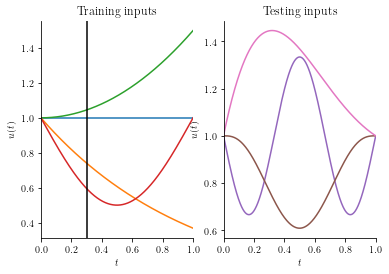

In [27]:
# Split into training / testing sets.
Us_all_train = Us_all[:4]
Us_all_test = Us_all[4:]

# Visualize the input functions.
fig, [ax1, ax2] = plt.subplots(1, 2)
c = 0
for U in Us_all_train:
    ax1.plot(t, U, color=f"C{c}")
    c += 1
for U in Us_all_test:
    ax2.plot(t, U, color=f"C{c}")
    c += 1

ax1.set_title("Training inputs")
ax2.set_title("Testing inputs")
ax1.axvline(t[k], color='k')
for ax in (ax1, ax2):
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$u(t)$")
plt.show()

We only record the first $k$ snapshots corresponding to each of the training inputs, so we are still predicting in time as in the previous section.

In [28]:
# Compute snapshots by solving the equation with implicit_euler().
Qs_all = [implicit_euler(t, q0, A, B, U) for U in Us_all]
Qs_all_train = Qs_all[:len(Us_all_train)]
Qs_all_test = Qs_all[len(Us_all_train):]

# Retain only the first k snapshots/inputs for training the ROM.
t_train = t[:k]                         # Temporal domain for training snapshots.
Qs = [Q[:, :k] for Q in Qs_all_train]   # Observed snapshots.

# Compute time derivatives (dq/dt) for each snapshot and stack training data.
Qdots_train = np.hstack([(Q[:, 1:] - Q[:, :-1]) / dt for Q in Qs])
Qs_train = np.hstack([Q[:, 1:k] for Q in Qs])
Us_train = np.hstack([U[1:k] for U in Us_all_train])

### ROM Construction

In [29]:
# Compute a basis from all of the training snapshots.
basis = opinf.pre.PODBasis().fit(np.hstack(Qs), residual_energy=1e-8)
print(basis)

# Express the initial condition in the coordinates of the new basis.
q0_ = basis.encode(q0)

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 7


In [30]:
# Train a reduced-order model using the training data.
rom = opinf.ContinuousOpInfROM(modelform="AB")
rom.fit(basis=basis, states=Qs_train, ddts=Qdots_train, inputs=Us_train)
print(rom)

Reduced-order model structure: dq / dt = Aq(t) + Bu(t)
Full-order dimension    n = 127
Input/control dimension m = 1
Reduced-order dimension r = 7


### ROM Evaluation

We now test the learned ROM on both the training and testing inputs.

In [31]:
def plot_errors_over_time_inputs(Q_ROMs, Q_trues, cidx=0):
    """Plot normalized absolute projection error and ROM errors
    as a function of time.

    Parameters
    ----------
    Q_ROMs : list((n, k) ndarrays)
        List of reduced-order model solutions.
    Q_trues : list(str)
        List of full-order model solutions.
    """
    fig, ax = plt.subplots(1, 1)
    
    for Q_ROM, Q_true in zip(Q_ROMs, Q_trues):
        rel_err = opinf.post.lp_error(Q_true, Q_ROM, normalize=True)[1]
        plt.semilogy(t, rel_err, color=f"C{cidx}")
        cidx += 1

    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel("Normalized absolute error")

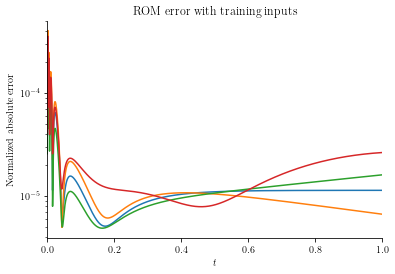

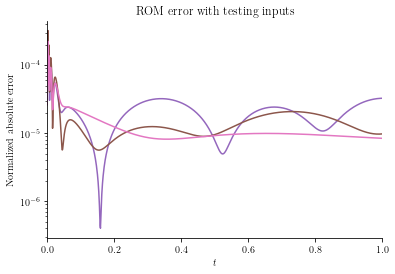

In [32]:
# Test ROM accuracy on the training inputs.
Qs_ROM_train = [
    basis.decode(implicit_euler(t, q0_, rom.A_.entries, rom.B_.entries, U))
    for U in Us_all_train
]
plot_errors_over_time_inputs(Qs_ROM_train, Qs_all_train)
plt.title("ROM error with training inputs")

# Test ROM accuracy on the testing inputs.
Qs_ROM_test = [
    basis.decode(implicit_euler(t, q0_, rom.A_.entries, rom.B_.entries, U))
    for U in Us_all_test
]
plot_errors_over_time_inputs(Qs_ROM_test, Qs_all_test,
                             cidx=len(Qs_ROM_train))
plt.title("ROM error with testing inputs")
plt.show()

In this experiment, the training and testing error are similar and small (less than 0.1%) throughout the time domain. We conclude this section by checking the average ROM error on the test inputs as a function of basis size.

In [33]:
def run_trial_inputs(r):
    """Do OpInf / intrusive ROM prediction with r basis vectors."""
    basis.r = r
    q0_ = basis.encode(q0)

    # Construct the intrusive ROM.
    rom_intrusive = opinf.ContinuousOpInfROM("AB").fit(basis, None, None,
                                                       known_operators={"A":A, "B":B})

    # Construct the operator inference ROM from the training data.
    rom_opinf = opinf.ContinuousOpInfROM(modelform="AB")
    rom_opinf.fit(basis=basis, states=Qs_train, ddts=Qdots_train, inputs=Us_train)

    # Test the ROMs at each testing input.
    projection_error, intrusive_error, opinf_error = 0, 0, 0
    for Q, U in zip(Qs_all_test, Us_all_test):

        # Simulate the intrusive ROM for this testing input.
        Q_ROM_intrusive = basis.decode(implicit_euler(t, q0_,
                                                      rom_intrusive.A_.entries,
                                                      rom_intrusive.B_.entries, U))

        # Simulate the operator inference ROM for this testing input.
        Q_ROM_opinf = basis.decode(implicit_euler(t, q0_,
                                                  rom_opinf.A_.entries,
                                                  rom_opinf.B_.entries, U))

        # Calculate errors.
        projection_error += basis.projection_error(Q, relative=True)
        intrusive_error += opinf.post.frobenius_error(Q, Q_ROM_intrusive)[1]
        opinf_error += opinf.post.frobenius_error(Q, Q_ROM_opinf)[1]

    # Average the relative errors.
    projection_error /= len(Us_all_test)
    intrusive_error /= len(Us_all_test)
    opinf_error /= len(Us_all_test)

    return projection_error, intrusive_error, opinf_error

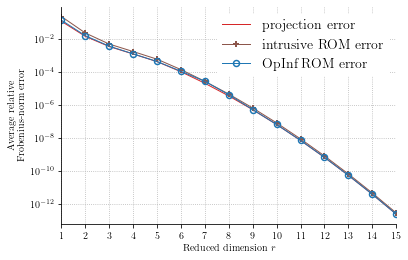

In [34]:
plot_state_error(15, run_trial_inputs, "Average relative\nFrobenius-norm error")

This experiment shows that the operator inference ROMs is robust to new boundary conditions; in other words, the ROM learns an input operator $\widehat{\mathbf{B}}$ that performs well for multiple choices of the input $u(t)$.

## Prediction in Parameter Space

Recall the governing equation,

$$
    \frac{\partial}{\partial t} q(x,t;{\color{teal}\mu})
    = {\color{teal}\mu}\frac{\partial^2}{\partial x^2}q(x,t;{\color{teal}\mu}).
$$

In this section we examine the role of the constant $\mu > 0$, the heat diffusivity parameter.

:::{admonition} Objective
:class: attention

Construct a ROM of the heat equation that can be solved for different choices of the diffusivity parameter $\mu > 0$.
We will observe data for a few values of $\mu$ and use the ROM to predict the solution for new values of $\mu$. As before, we also aim to be predictive in time.
:::

### Full-order Model Definition

We solved this problem earlier for fixed $\mu = 1$.
For variable $\mu$, {eq}`eq_heat_fom_parametric` defines the full-order model:

$$
    \frac{\text{d}}{\text{d}t}\mathbf{q}(t;\mu)
    = \mathbf{A}(\mu)\mathbf{q}(t;\mu) + \mathbf{B}(\mu)u(t),
    \qquad
    \mathbf{q}(0;\mu)
    = \mathbf{q}_0.
$$

Note that $\mathbf{A}(\mu) = \mu \mathbf{A}(1)$ and $\mathbf{B}(\mu) = \mu \mathbf{B}(1)$, and that $\mathbf{A}(1)$ and $\mathbf{B}(1)$ are the full-order operators we constructed previously.

### Training Data Generation

We consider the parameter domain $\mathcal{D} = [.1, 10] \subset \mathbb{R}$.
Taking $s$ logarithmically spaced samples $\{\mu_i\}_{i=1}^{s}\subset\mathcal{D}$, we solve the full-order model over $[0, T']$ for each parameter sample.
For each parameter $\mu_{i}$, the resulting snapshots matrix is denoted as $\mathbf{Q}(\mu_{i})\in \mathbb{R}^{n \times k}$.
We choose $s = 10$ training parameters in the following experiment.

In [35]:
s = 10                          # Number of parameter samples.
params = np.logspace(-1, 1, s)  # Get s logarithmically spaced values of µ from D = [.1, 10].

# Retain only the first k snapshots/inputs for training the ROM.
k = 600                         # Number of training snapshots.
t_train = t[:k]                 # Temporal domain for training snapshots.
U_train = U_all[:k]

# Solve the full-order model at each of the parameter samples.
Qs = [implicit_euler(t_train, q0, µ * A, µ * B, U_train) for µ in params]
Qdots_train = [(Q[:, 1:] - Q[:, :-1]) / dt for Q in Qs]
Qs_train = [Q[:, 1:] for Q in Qs]
Us_train = [U_train[1:] for _ in Qs]

### ROM Construction

A (global) POD basis can be constructed from the concatenation of the individual snapshot matrices,

$$
    \mathbf{Q}
    = \left[~\mathbf{Q}(\mu_1)~\cdots~\mathbf{Q}(\mu_s)~\right]
    \in\mathbb{R}^{n \times sk}.
$$

We can select the reduced dimension $r$ as before by examining the residual energy of the singular values.

PODBasis
Full-order dimension    n = 127
Reduced-order dimension r = 8


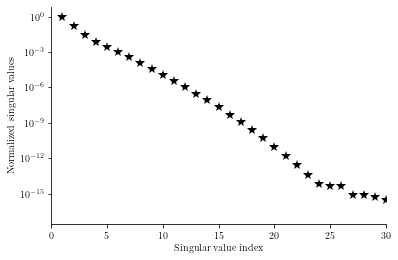

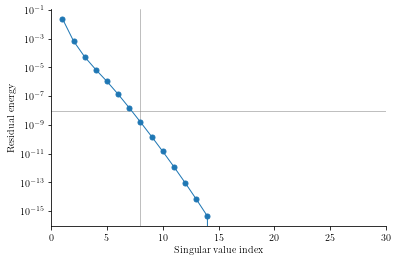

In [36]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.pre.PODBasis().fit(np.hstack(Qs), residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 30)

# Check the decay of the residual energy based on the singular values.
basis.plot_residual_energy(threshold=1e-8)
plt.xlim(0, 30)
plt.show()

Alternatively, we could choose $r$ so that the average relative projection error,

$$
    \text{avgerr}_\text{proj} = \frac{1}{s}\sum_{i=1}^{s}\frac{||\mathbf{Q}(\mu_i) - \mathbf{V}_r \mathbf{V}_r^{\top}\mathbf{Q}(\mu_i)||_F}{||\mathbf{Q}(\mu_i)||_F},
$$

is below a certain threshold, say $10^{-5}$.

In [37]:
def average_relative_projection_error(r):
    """Compute the average relative projection error with r basis vectors."""
    oldr = basis.r
    basis.r = r
    avgerr = np.mean([basis.projection_error(Q, relative=True) for Q in Qs])
    basis.r = oldr
    return avgerr

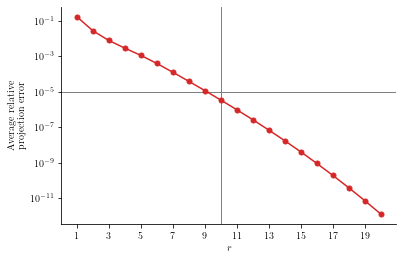

In [38]:
fig, ax = plt.subplots(1, 1)
rs = np.arange(1, 21)
ax.axhline(1e-5, color="gray", lw=1)
ax.axvline(10, color="gray", lw=1)
ax.semilogy(rs, [average_relative_projection_error(r) for r in rs],
            "C3.-", ms=10)
ax.set_xticks(rs[::2])
ax.set_xlabel(r"$r$")
ax.set_ylabel("Average relative\nprojection error")
plt.show()

Based on these criteria, we choose $r = 10$.

In [39]:
basis.r = 10

### Interpolatory Operator Inference

There are several strategies to account for the parameter $\mu$. The reduced-order operators obtained through intrusive projection are given by

$$
    \widetilde{\mathbf{A}}(\mu)
    = \mathbf{V}_{r}^{\mathsf{T}} \mathbf{A}(\mu) \mathbf{V}_{r},
    \qquad
    \widetilde{\mathbf{B}}(\mu)
    = \mathbf{V}_{r}^{\mathsf{T}} \mathbf{B}(\mu).
$$

Here, we perform interpolation on the entries of the reduced-order operators learned for each parameter sample. This means we learn a separate ROM for each $\mu_i$, $i=1, \ldots, s$, obtaining reduced-order operators $\widehat{\mathbf{A}}(\mu_{i})$ and $\widehat{\mathbf{B}}(\mu_{i})$.
Then, for a new parameter value $\bar{\mu}\in\mathcal{D}$, we interpolate the entries of the learned reduced model operators to create a new reduced model corresponding to $\bar{\mu}\in\mathcal{D}$.
<!-- 
$$
    \widehat{\mathbf{A}}(\bar{\mu})_{i,j}
    = \text{interpolate}\left(\mathbf{A}(\mu_{1})_{i,j}, \ldots, \mathbf{A}(\mu_{s})_{i,j}; \bar{\mu}\right)
$$
 -->
The `InterpolatedContinuousOpInfROM` class encapsulates this process.

In [40]:
# Learn reduced models for each parameter value.
rom = opinf.InterpolatedContinuousOpInfROM("AB")
rom.fit(basis=basis, parameters=params, states=Qs_train, ddts=Qdots_train, inputs=Us_train)

Reduced-order model structure: dq / dt = Aq(t) + Bu(t)
Full-order dimension    n = 127
Input/control dimension m = 1
Reduced-order dimension r = 10

:::{tip}
If we can construct $\mathbf{A}(\mu_{i})$ and $\mathbf{B}(\mu_{i})$ for each parameter sample, then we can learn an intrusive interpolatory ROM with `InterpolatedContinuousOpInfROM` through the `known_operators` argument.

```python
>>> rom_intrusive = opinf.InterpolatedContinuousOpInfROM("AB")
>>> rom_intrusive.fit(basis, params, None, None,
                      known_operators={"A": [µ * A for µ in params],
                                       "B": [µ * B for µ in params]})
```
:::

### ROM Evaluation

To test the ROM, we take $s$ logarithmically distributed random samples in $\mathcal{D}$ and compute the average relative state error,

$$
    \text{avgerr}_\text{ROM} = \frac{1}{s}\sum_{i=1}^{s}\frac{||\mathbf{Q}(\mu_i) - \mathbf{Q}_{\text{ROM}}(\mu_i)||_F}{||\mathbf{Q}(\mu_i)||_F},
$$

where $\mathbf{Q}_{\text{ROM}}(\mu_{i})$ is the ROM solution at parameter $\mu_{i}$.

In [41]:
params_test = np.sort(10**np.random.uniform(-1, 1, s))
params_test

array([0.10257404, 0.39431211, 0.48006   , 0.82836728, 2.18070414,
       2.77712831, 3.11035673, 5.17369774, 8.57556041, 9.04735179])

In [42]:
def run_trial_parametric(r):
    """Do OpInf / intrusive ROM prediction with r basis vectors."""
    basis.r = r
    q0_ = basis.encode(q0)

    # Compute the intrusive ROM.
    rom_intrusive = opinf.InterpolatedContinuousOpInfROM("AB")
    rom_intrusive.fit(basis, params, None, None,
                      known_operators={"A": [µ * A for µ in params],
                                       "B": [µ * B for µ in params]})

    # Learn an operator inference ROM from the training data.
    rom_opinf = opinf.InterpolatedContinuousOpInfROM("AB")
    rom_opinf.fit(basis, parameters=params, states=Qs_train, ddts=Qdots_train, inputs=Us_train)

    # Test the ROM at each parameter in the test set.
    projection_error, intrusive_error, opinf_error = 0, 0, 0
    for µ in params_test:

        # Solve the FOM at this parameter value.
        Aµ = µ * A
        Bµ = µ * B
        Q_FOM = implicit_euler(t, q0, Aµ, Bµ, U_all)

        # Simulate the intrusive ROM at this parameter value.
        romµ = rom_intrusive(µ)
        Q_ROM_intrusive = basis.decode(implicit_euler(t, q0_, romµ.A_.entries, romµ.B_.entries, U_all))

        # Simulate the interpolating OpInf ROM at this parameter value.
        romµ = rom_opinf(µ)
        Q_ROM_opinf = basis.decode(implicit_euler(t, q0_, romµ.A_.entries, romµ.B_.entries, U_all))

        # Calculate errors.
        projection_error += basis.projection_error(Q_FOM, relative=True)
        intrusive_error += opinf.post.frobenius_error(Q_FOM, Q_ROM_intrusive)[1]
        opinf_error += opinf.post.frobenius_error(Q_FOM, Q_ROM_opinf)[1]

    # Average the relative errors.
    projection_error /= len(params_test)
    intrusive_error /= len(params_test)
    opinf_error /= len(params_test)

    return projection_error, intrusive_error, opinf_error

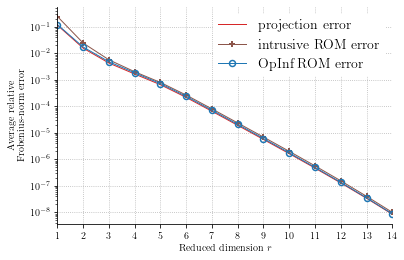

In [43]:
plot_state_error(14, run_trial_parametric, "Average relative\nFrobenius-norm error")